<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Проверка-качества-данных" data-toc-modified-id="Проверка-качества-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка качества данных</a></span></li><li><span><a href="#Лемматация-и-очистка-данных" data-toc-modified-id="Лемматация-и-очистка-данных-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Лемматация и очистка данных</a></span></li></ul></li><li><span><a href="#Деление-выборки-на-обучение-и-тестирование" data-toc-modified-id="Деление-выборки-на-обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Деление выборки на обучение и тестирование</a></span></li><li><span><a href="#Векторизация-данных" data-toc-modified-id="Векторизация-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Векторизация данных</a></span></li><li><span><a href="#Обучение-после-оценки-важности-слова-определяется-величиной-TF-IDF" data-toc-modified-id="Обучение-после-оценки-важности-слова-определяется-величиной-TF-IDF-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение после оценки важности слова определяется величиной TF-IDF</a></span><ul class="toc-item"><li><span><a href="#Функция-проверки-качества-моделей." data-toc-modified-id="Функция-проверки-качества-моделей.-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Функция проверки качества моделей.</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></li></ul></div>

# Подготовка данных

## Импорт библиотек

In [49]:
import numpy as np
import pandas as pd
from random import randint
import transformers
import re 
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score

## Загрузка данных

In [21]:
df_comments = pd.read_csv("df_comments.csv")

### Проверка качества данных

In [22]:
def find_isna(df):
    cnt_na = df.isna().sum(axis=1).clip(upper=1).sum()
    cnt_rows = df[df.columns[0]].count()
    print(f'Количество записей в выборке пустых: {cnt_na}')
    print('TOP 20')
    column_isna = pd.DataFrame(df.isna().sum())
    column_isna.columns = ['count']
    display(column_isna.loc[column_isna['count'] != 0].sort_values(by = 'count', ascending=False).head(20))

In [23]:
def primary_view(df):
    print(f'Выборка содержит {len(df.columns)} столбцов и {df.shape[0]} строки')
    print('----------------------------------------------------------------------------------------------------------------')
    print(f'В плане пропусков следующая картина')
    find_isna(df)
    print('----------------------------------------------------------------------------------------------------------------')
    print('Распределение данных (суммарное) выглядит таким образом')
    display(df.describe().T)
    print('----------------------------------------------------------------------------------------------------------------')
    #Если необходимо, можно выводить, но иногда оченб много занимает места.
    #! Необходимо написать функцию для автоанализа типов данных на случай замены на более оптимальный тип для экономии ресурсов
    #print(df.info())
    print('----------------------------------------------------------------------------------------------------------------')
    print('Срез данных для примера:')
    display(df.head())

In [24]:
primary_view(df_comments)

Выборка содержит 2 столбцов и 159571 строки
----------------------------------------------------------------------------------------------------------------
В плане пропусков следующая картина
Количество записей в выборке пустых: 0
TOP 20


,count


----------------------------------------------------------------------------------------------------------------
Распределение данных (суммарное) выглядит таким образом


,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.101679,0.302226,0.0,0.0,0.0,0.0,1.0


----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------
Срез данных для примера:


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Лемматация и очистка данных

In [25]:
df = df_comments
df['text'] = df['text'].str.lower()
m = WordNetLemmatizer()

def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

def lemmatize_(row):
    lemm_text = clear_text(row['text'])
    word_list = nltk.word_tokenize(lemm_text)
    lemmatized_output = ' '.join([m.lemmatize(w) for w in word_list])
    return lemmatized_output

df['lemma_text'] = df.apply(lemmatize_, axis=1)

In [26]:
print('Данные прошли обработку.',df.shape)
display(df.head())

Данные прошли обработку. (159571, 3)


,text,toxic,lemma_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


# Обучение модели

## Деление выборки на обучение и тестирование

In [27]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=12345)

## Векторизация данных

In [28]:
corpus_train = df_train['lemma_text'].values.astype('U')
corpus_test = df_test['lemma_text'].values.astype('U')
tf_idf = TfidfVectorizer()

## Обучение после оценки важности слова определяется величиной TF-IDF

In [29]:
X_train = tf_idf.fit_transform(corpus_train) 
target = df_train['toxic']
features = X_train

### Функция проверки качества моделей.

In [30]:
def run_model(X, y):
    random_state = 12345
    best_f1 = 0
    best_model = None
    rezult = []
    
    for i in np.linspace(0.05,1,9):
        model = LogisticRegression(random_state = random_state, solver='liblinear', C=i)
        f1 = cross_val_score(estimator=model, X=X, y=y,cv=5, scoring='f1').mean()
        
        if f1 > best_f1:
            best_f1 = f1
            best_model = model

    return  best_f1, best_model

### Обучение модели

In [31]:
train_f1, best_model = run_model(features, target)
print('Максмальный результат f1 до обучения', train_f1)
print(best_model)

Максмальный результат f1 до обучения 0.7238409808404225
LogisticRegression(random_state=12345, solver='liblinear')


In [32]:
best_model.fit(features, target)
predicted_valid = best_model.predict(features)
f1 = round(f1_score(target, predicted_valid), 5)
print('f1 лучшей модели после обучени', f1)

f1 лучшей модели после обучени 0.7725


In [56]:
def roc_result(df_ft, df_tg, model):
    probabilities_valid = model.predict_proba(df_ft)
    probabilities_one = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(df_tg, probabilities_one)
    print('ROC-кривая = ', auc_roc)

    fpr, tpr, thresholds = roc_curve(df_tg, probabilities_one) 
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show() 

ROC-кривая =  0.9850071678180621


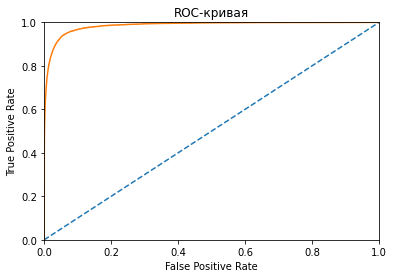

In [57]:
roc_result(features, target, best_model)

### Тестирование модели

In [33]:
X_test = tf_idf.transform(corpus_test)

target_test = df_test['toxic']
features_test = X_test

predicted_test = best_model.predict(features_test)
f1 = round(f1_score(target_test, predicted_test), 5)
print('f1 тестовой выборки', f1)

f1 тестовой выборки 0.75248


ROC-кривая =  0.9736451541645849


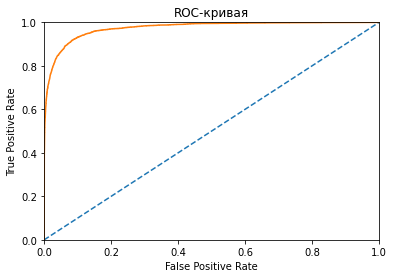

In [58]:
roc_result(features_test, target_test, best_model)